In [12]:
#Building makemore Part 3: Activations & Gradients, BatchNorm(https://youtu.be/P6sfmUTpUmc?si=Q5mgzxg49be-SR1L)

In [13]:
import torch
import torch.nn.functional as F

#draw the plot outside results
%matplotlib inline
from matplotlib import pyplot as plt

chars = ['.'] + [chr(i + ord('a')) for i in range(26)]
stoi = {s:i for i,s in enumerate(chars)}
itos = {stoi[v]:v for v in stoi}

In [14]:
import random

def crete_training_data(words, context_length):
    xs = []
    ys = []
    for w in words:
        #print(w)
        context = [stoi['.']]*context_length
        for ch in w + '.':
            ix = stoi[ch]
            xs.append(context)
            ys.append(ix)
            #print(f'{''.join([itos[i] for i in context])} -> {itos[ix]}')
            context = context[1:] + [ix] # rolling window
    return torch.tensor(xs), torch.tensor(ys)

def crete_training_data_with_split(words, context_length, selection_randomization_seed, test_spilit=(0.8,0.1,0.1)):
    random.seed(selection_randomization_seed)
    random.shuffle(words)
    outs = []

    sum_for_test_split = sum(s for s in test_spilit)
    normalized_test_split = [s/sum_for_test_split for s in test_spilit]
    last_start = 0
    for i,s in enumerate(normalized_test_split):
        start = last_start
        if i > 0:
            start += int(normalized_test_split[i - 1] * len(words))
        last_start = start
        end = start + int(s * len(words))
        if i + 1 == len(normalized_test_split):
            end = len(words)
        #print(start,end,len(words))
        xs,ys = crete_training_data(words[start:end],context_length)
        outs.append((xs,ys))
    return outs

In [127]:
class Linear:
    #fan_in number of inputs aka the number of columns in the matrix aka number of activations
    #fan_out number of rows in the matrix aka number of neurons
    def __init__(self, fan_in, fan_out, g, bias=True):
        self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None

    #xs input
    def __call__(self, xs):
        self.out = xs @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

#recentering layer
class BatchNorm1d:
    def __init__(self, dim, eps = 1e-5, momentum=0.1, training=True):
        self.eps = eps
        self.momentum = momentum
        self.training = training
        #trained with backprop
        self.gamma = torch.ones(dim) #gain
        self.beta = torch.zeros(dim) #bias
        #buffers(we don't consider this in the backprop)
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, xs):
        #forward pass
        xmean = None
        xvar = None
        if self.training:
            xmean = xs.mean(0, keepdim=True)
            xvar = xs.var(0, keepdim=True)
        else:
            xmean = self.running_mean
            xvar = self.running_var

        xhat = (xs - xmean) / torch.sqrt(xvar + self.eps)
        self.out = self.gamma * xhat + self.beta

        #update the buffers outside backprop
        if self.training:
            with torch.no_grad():
                self.running_mean = xmean * self.momentum + self.running_mean * (1.0 - self.momentum)
                self.running_var = xvar * self.momentum + self.running_var * (1.0 - self.momentum)
        return self.out

    def parameters(self):
        return [self.gamma, self.beta]

class Tanh:
    def __call__(self, xs):
        self.out = torch.tanh(xs)
        return self.out

    def parameters(self):
        return []


def create_concrete_training_data(embading_size):
    words = open('names.txt', 'r').read().split()
    return crete_traininng_data(words, embading_size)

def crate_model_parameters(alphabet_size, num_embading_dimensions, embading_size, number_of_neurons_in_the_hiden_layer, generator_seed):
    g = torch.Generator().manual_seed(generator_seed)
    #embeding space
    C = torch.randn((alphabet_size, num_embading_dimensions), generator=g)
    layers = [
        Linear(num_embading_dimensions * embading_size, number_of_neurons_in_the_hiden_layer, g), Tanh(),
        Linear(   number_of_neurons_in_the_hiden_layer, number_of_neurons_in_the_hiden_layer, g), Tanh(),
        Linear(   number_of_neurons_in_the_hiden_layer, number_of_neurons_in_the_hiden_layer, g), Tanh(),
        Linear(   number_of_neurons_in_the_hiden_layer, number_of_neurons_in_the_hiden_layer, g), Tanh(),
        Linear(   number_of_neurons_in_the_hiden_layer, number_of_neurons_in_the_hiden_layer, g), Tanh(),
        Linear(   number_of_neurons_in_the_hiden_layer,                        alphabet_size, g),
    ]

    with torch.no_grad():
        #output layer decrese confidence
        layers[-1].weight *= 0.1
        for l in layers[:-1]:
            if isinstance(l, Linear):
                l.weight *= 5/3 # this is a magical value for networks that are layers of [something + Tanh]*n

    parameters = [C] + [p for layer in layers for p in layer.parameters()]

    for p in parameters:
        p.requires_grad = True
        
    return g, parameters, C, layers

def calculate_loss(C, layers, xs ,ys):
    emb = C[xs]
    x = emb.view(emb.shape[0], -1)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, ys)
    return loss

def train(parameters, C, layers, xs, ys, generator, max_steps, batch_size, traininig_switch_point, keep_learnging_rate_stats):
    lossi = []
    ud = []
    
    for i in range(max_steps):
        # minibatch construct
        ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
        Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
        
        # forward pass
        loss = calculate_loss(C, layers, Xb ,Yb)
        
        # backward pass
        for layer in layers:
            layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
        for p in parameters:
            p.grad = None
        loss.backward()
        
        # update
        lr = 0.1 if i < traininig_switch_point else 0.01 # step learning rate decay
        for p in parameters:
            p.data += -lr * p.grad
        
        # track stats
        if i % (max_steps/10) == 0: # print every once in a while
            print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
            lossi.append(loss.log10().item())

        if keep_learnging_rate_stats:
            with torch.no_grad():
                ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

    return ud

@torch.no_grad
def forward(parameters, C, layers , xs):
    emb = C[xs]
    x = emb.view(emb.shape[0], -1)
    for l in layers:
        x = l(x)
    return F.softmax(x, dim=1)

@torch.no_grad
def generate_name(parameters, C, layers, generator, num_embading_dimensions):
    ixs = [0]*num_embading_dimensions
    out = []
    while True:
        prob = forward(parameters,C,layers, torch.tensor([ixs]))
        ix = torch.multinomial(prob, 1, True, generator = generator)
        if ix == 0:
            return ''.join([itos[i] for i in out])
        ixs = ixs[1:] + [ix]
        out.append(ix.item())
    return out

In [128]:
words = open('names.txt', 'r').read().split()

embeding_size = 10

data_spilit=(0.8,0.1,0.1)
training_data = crete_training_data_with_split(words, embeding_size, 42, data_spilit)
Xtr,Ytr = training_data[0]
Xdev,Ydev = training_data[1]
Xte,Yte = training_data[2]

print(f'training data size = {Xtr.shape[0]}, input size ={int(len(words) * data_spilit[0])}')
print(f'dev data size = {Xdev.shape[0]}, input size ={int(len(words) * data_spilit[1])}')
print(f'dev data size = {Xte.shape[0]}, input size ={int(len(words) * data_spilit[2])}')

training data size = 182625, input size =25626
dev data size = 22655, input size =3203
dev data size = 22866, input size =3203


In [129]:
alphabet_size = 27
num_embading_dimensions = 2
number_of_hiden_nerons = 100
generator_seed = 214_748_364_7
learning_ratre = 1

#create model
g, parameters, C, layers = crate_model_parameters(alphabet_size, num_embading_dimensions, embeding_size, number_of_hiden_nerons, generator_seed)
num_parameters = sum(p.nelement() for p in parameters[1:])
print(f'num parameters = {num_parameters}')

num parameters = 45227


In [130]:
max_steps = 2000
batch_size = 32
switch_point = 150000
ud = train(parameters, C, layers, Xtr, Ytr, g, max_steps, batch_size, switch_point, True)

      0/   2000: 3.2974
    200/   2000: 2.6886
    400/   2000: 2.8738
    600/   2000: 2.3167
    800/   2000: 2.9007
   1000/   2000: 2.7919
   1200/   2000: 2.2315
   1400/   2000: 2.3617
   1600/   2000: 2.3509
   1800/   2000: 2.3414


In [120]:
for _ in range(10):
    print(generate_name(parameters, C, layers, g, embeding_size))

asmallan
mahmah
cashree
develyn
wans
benreey
beyakain
delaliy
taiava
todallan


layer1(Tanh): mean: 2.622676947794389e-05, std: 0.002930241171270609, saturation: 0.0%
layer3(Tanh): mean: 2.9075323254801333e-05, std: 0.002624408109113574, saturation: 0.0%
layer5(Tanh): mean: 1.8473714362698956e-06, std: 0.0027095633558928967, saturation: 0.0%
layer7(Tanh): mean: -6.640503852395341e-05, std: 0.003042113035917282, saturation: 0.0%
layer9(Tanh): mean: 7.202029519248754e-05, std: 0.0031576280016452074, saturation: 0.0%


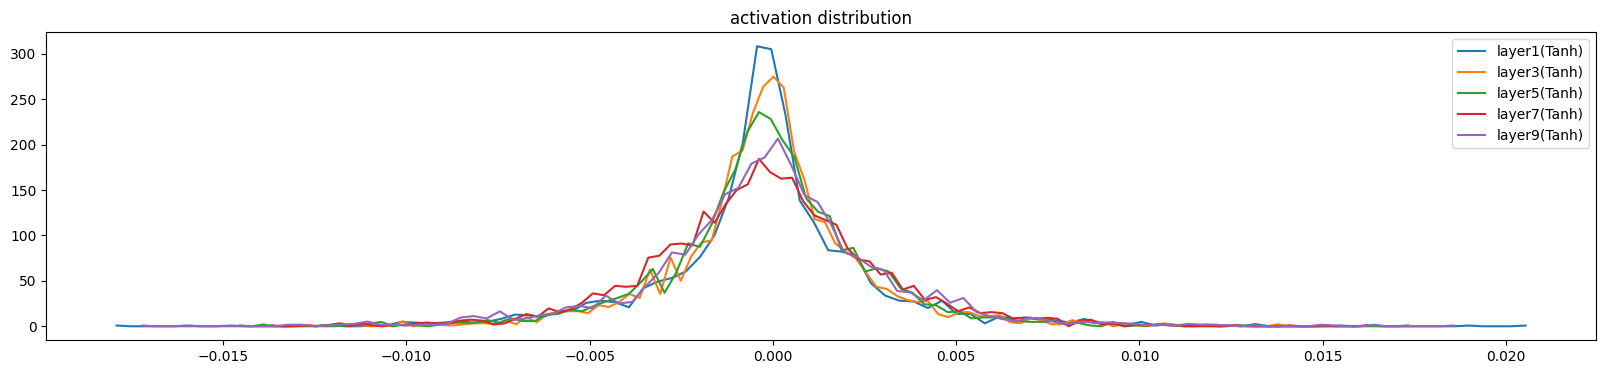

In [123]:
#tenh layers histogram
plt.figure(figsize=(20,4))
legends=[]
for i, layer in enumerate(layers[:-1]):
    if layer.__class__.__name__ == 'Tanh': # for some reason isinstance was failing idk python...
        t = layer.out.grad #if we want to see the grad retain_grad must be called before and it will be lost if an op is performed on the data
        print(f'layer{i}({layer.__class__.__name__}): mean: {t.mean()}, std: {t.std()}, saturation: {((t.abs() > 0.97).float().mean()*100.0)}%')
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(),hy.detach())
        legends.append(f'layer{i}({layer.__class__.__name__})')
plt.legend(legends)
plt.title('activation distribution')
plt.draw()

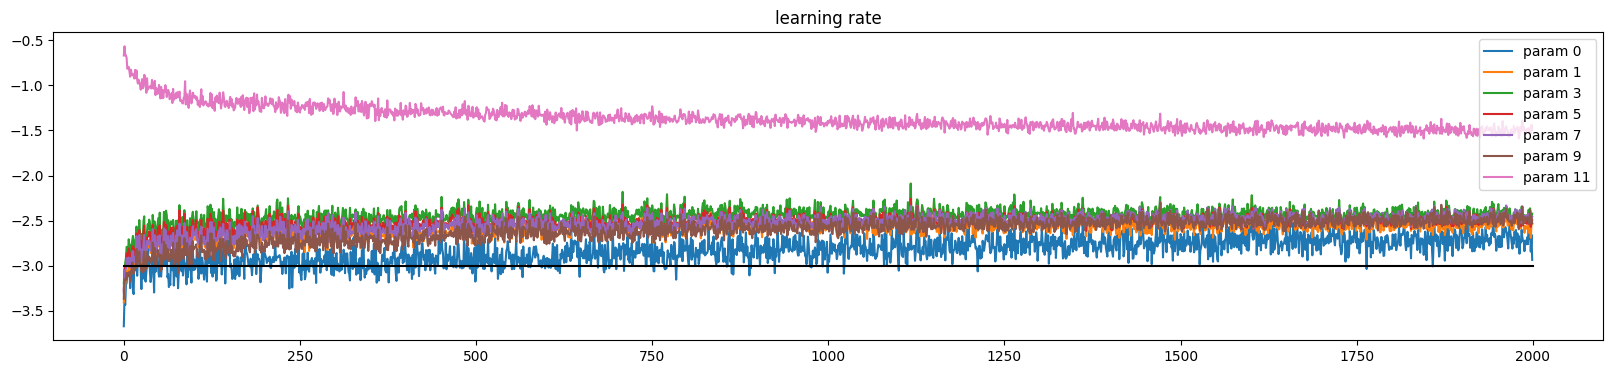

In [137]:
plt.figure(figsize=(20,4))
legends=[]
for i, p in enumerate(parameters):
    if p.ndim == 2:
        plt.plot([ud[j][i] for j in range(len(ud))])
        legends.append(f'param {i}')
plt.legend(legends)
plt.plot([0, len(ud)],[-3,-3], 'k') # artificial learning rate aprx 1e-3, this should be the learning rate that we strive for
plt.title('learning rate')
plt.draw()